In [1]:
import librosa
import os
import matplotlib.pyplot as plt
import librosa.display
import numpy as np

/home/griano/anaconda3/envs/EE382V/lib/python3.8/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


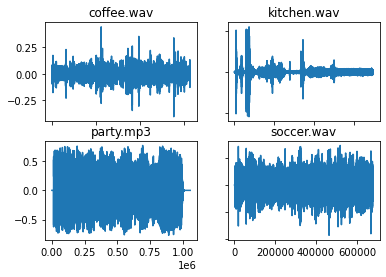

In [2]:
fnames = ['coffee.wav', 'kitchen.wav', 'party.mp3', 'soccer.wav']
fpaths = [os.path.join(os.getcwd(), os.pardir, s) for s in fnames]

fig, ax = plt.subplots(2,2)
ax = ax.flat
y = []; sr = []; y_percussive = []; y_harmonic = []

for i, fpath in enumerate(fpaths):
    y_i, sr_i = librosa.load(fpath)
    y.append(y_i)
    y_percussive.append(librosa.effects.percussive(y[i]))
    y_harmonic.append(librosa.effects.harmonic(y[i]))
    sr.append(sr_i)
    ax[i].plot(y[i])
    ax[i].set_title(fnames[i])
    ax[i].label_outer() 
    

## Feature selection

In order to capture differences among sound signals, the SFFT is computed and the spectrogram is then scaled to Mel scal so that frequency values are averaged over the scale, thus producing a simpler feature representation, which is still good enough to perceive differences among signals.

- The window size of the sliding window is chosen ranging from 0.1 to 5 seconds, after several trials I noticed that 0.4 provided best results
- The number of mels or features captured for recognition was also chosen after several tests, ranging from 10 mel to 100 mels

In [4]:
windows_size = 0.4 # [s]
n_mels = 65

S_DB = []
labels = []
for i in range(4):
    duration = len(y[i]) / sr[i]
    n_frames = duration // windows_size
    hop_length = int(len(y[i]) // n_frames)
    
    S = librosa.feature.melspectrogram(y[i], sr=sr[i], hop_length=hop_length, n_mels=n_mels)
    S_DB.append(librosa.power_to_db(S, ref=np.max).T)
    labels.append( np.ones(S.shape[1])*i )

S_DB = np.concatenate(S_DB)
labels = np.hstack(labels)
data = np.vstack((S_DB.T, labels)).T

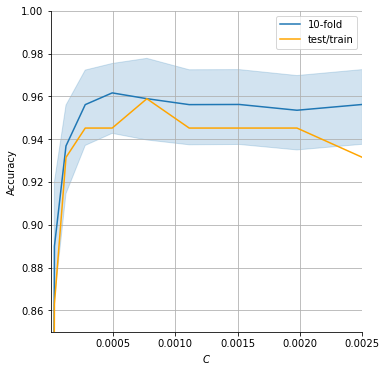

In [5]:
from sklearn import svm
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, plot_confusion_matrix
import seaborn as sns

# Feature Extraction
X, X_test, Y, Y_test = train_test_split(
        data[:,:-1], data[:,-1], test_size=0.2, random_state=24)
X2, X_val, Y2, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=42)

# SVM
k = 10 # 10-fold
C = np.power(np.linspace(1e-5, 5e-2, num=k), 2)
SVM_cv_scores = np.zeros(k*k)
SVM_split_scores = np.zeros(k)
plot_c = np.repeat(C, k)
for i, c in enumerate(C):
    clf = svm.SVC(kernel = 'linear', C = c, decision_function_shape = 'ovr')

    # 10-fold cross-validation
    cv_scores = cross_val_score(clf, X, Y, cv=k)
    SVM_cv_scores[i*k:i*k+k] = cv_scores

    # Split test/train
    clf.fit(X2, Y2)
    Y_pred = clf.predict(X_val)
    SVM_split_scores[i] = accuracy_score(Y_val, Y_pred)

ax = sns.relplot(x = plot_c, y = SVM_cv_scores, kind='line')
plt.plot(C,SVM_split_scores, 'orange', linewidth = 1.5)
plt.xlabel("$C$")
plt.ylabel("Accuracy")
ax.set(ylim = (0.85, 1))
ax.set(xlim = (C[0], C[-1]))
plt.legend(['10-fold', 'test/train'])
plt.grid()
avg_SVM_cv_scores = SVM_cv_scores.reshape((k,k)).mean(axis = 1)
C = C[np.argmax(avg_SVM_cv_scores)]

Test Score
SVM: 0.967032967032967


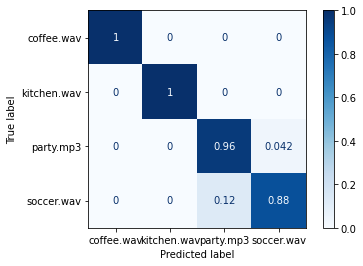

In [6]:
# %% Test
clf = svm.SVC(kernel = 'linear', C = C, decision_function_shape = 'ovr')
clf.fit(X, Y)
Y_pred = clf.predict(X_test)
clf_test_score = accuracy_score(Y_test, Y_pred)
print('Test Score')
print(f'SVM: {clf_test_score}')

# %% Confusion Matrix
plot_confusion_matrix(clf, X_test, Y_test,
                        display_labels=fnames,
                        cmap=plt.cm.Blues,
                        normalize = 'true')